<xarray.Dataset> Size: 3MB
Dimensions:    (y: 292, x: 362)
Dimensions without coordinates: y, x
Data variables:
    atlmsk     (y, x) float32 423kB ...
    glomsk     (y, x) float32 423kB ...
    indmsk     (y, x) float32 423kB ...
    indpacmsk  (y, x) float32 423kB ...
    nav_lat    (y, x) float32 423kB ...
    nav_lon    (y, x) float32 423kB ...
    pacmsk     (y, x) float32 423kB ...
Attributes:
    ece-comment:  Based on SHACONEMO INPUTS_ORCA1_LIM3_PISCES_V9/eORCA_R1_sub...
    ece-origin:   UFla (SMHI) for EC-Earth
Coordinates:
    *empty*
Variables in the mask dataset: ['atlmsk', 'glomsk', 'indmsk', 'indpacmsk', 'nav_lat', 'nav_lon', 'pacmsk']
<xarray.DataArray 'atlmsk' (y: 292, x: 362)> Size: 423kB
[105704 values with dtype=float32]
Dimensions without coordinates: y, x
Attributes:
    long_name:  atlantic ocean without med sea


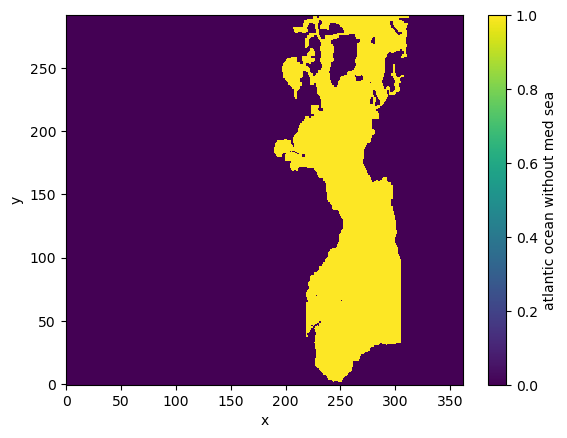

In [ ]:
import xarray as xr

# -----------------------------
# 1. Load the mask
# -----------------------------
mask_file = "/data/users/mde/FREJA/subbasins.nc"
mask_ds = xr.open_dataset(mask_file)

# -----------------------------
# 2. Inspect the dataset
# -----------------------------
print(mask_ds)  # prints dimensions, coordinates, and data variables
print(mask_ds.coords)  # prints coordinate variables

# -----------------------------
# 3. List the variables
# -----------------------------
print("Variables in the mask dataset:", list(mask_ds.data_vars))

# -----------------------------
# 4. View one of the variables (for example, the first one)
# -----------------------------
first_var_name = list(mask_ds.data_vars)[0]
mask_data = mask_ds[first_var_name]
print(mask_data)  # prints the DataArray with values and coordinates

# -----------------------------
# 5. Optional: quick plot to see the mask
# -----------------------------
mask_data.plot()




In [ ]:
import xarray as xr
import numpy as np
# 1. Load the mask (auto-detect variable and align to thetao grid)
# -----------------------------
mask_file = "/data/users/mde/FREJA/subbasins.nc"
mask_ds = xr.open_dataset(mask_file)

# load thetao to get its grid
thetao_file = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
thetao = xr.open_dataset(thetao_file)['thetao']

# Auto-detect a mask variable that has lat/lon dims; fall back to the first data var
mask_vars = list(mask_ds.data_vars)
candidates = [v for v in mask_vars if (any(k in mask_ds[v].dims for k in ['latitude','lat','y','j']) and any(k in mask_ds[v].dims for k in ['longitude','lon','x','i']))]
mask_var = candidates[0] if candidates else mask_vars[0]
print("Using mask variable:", mask_var)
mask = mask_ds[mask_var].squeeze()

# -----------------------------
# 2. Align/interpolate mask to the thetao horizontal grid (nearest neighbour)
# -----------------------------
thetao_grid = thetao.isel(time=0).drop_vars([v for v in thetao.coords if v == 'time' or v == 'lev']) if 'time' in thetao.coords else thetao.isel(time=0)
# Ensure mask and thetao_grid have compatible dimensions for interpolation
if 'latitude' in mask.coords and 'longitude' in mask.coords:
    mask_on_grid = mask.interp(latitude=thetao_grid['latitude'], longitude=thetao_grid['longitude'], method='nearest')
elif 'lat' in mask.coords and 'lon' in mask.coords:
    mask_on_grid = mask.interp(lat=thetao_grid['lat'], lon=thetao_grid['lon'], method='nearest')
elif 'nav_lat' in mask_ds.data_vars and 'nav_lon' in mask_ds.data_vars:
    # Use nav_lat and nav_lon from mask_ds for interpolation
    mask_on_grid = mask.interp(
        y=thetao_grid['j'], x=thetao_grid['i'],
        kwargs={"fill_value": None},
        method='nearest'
    )
else:
    raise ValueError("Mask does not have recognizable latitude/longitude coordinates for interpolation.")

# Build a boolean mask (True inside the region). Treat non-zero & finite as inside.
mask_bool = (np.isfinite(mask_on_grid)) & (mask_on_grid != 0)

# save the mask for future reference
# mask_bool.to_netcdf("mask_bool2.nc")

Using mask variable: atlmsk


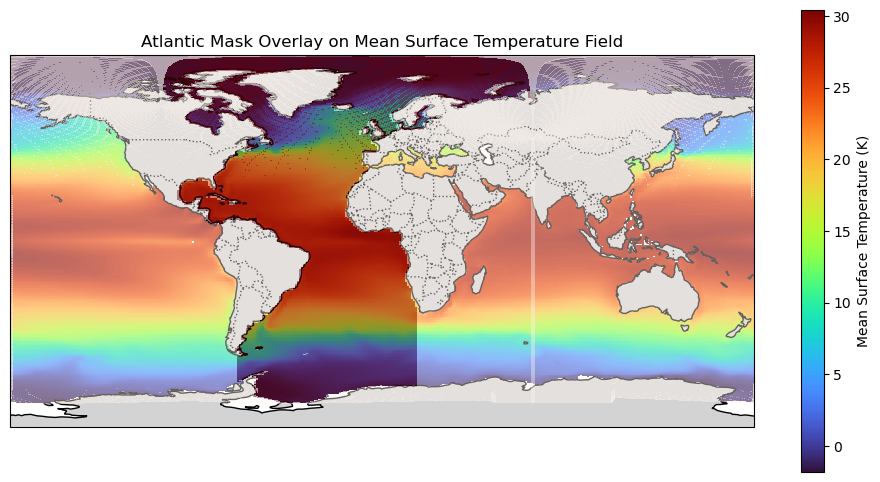

In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# 1. Load datasets
# -----------------------------
thetao_file = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
mask_file = "/data/users/frekle/Master_project2026/EOF/mask_bool.nc"

thetao_ds = xr.open_dataset(thetao_file)
mask_ds = xr.open_dataset(mask_file)

# Extract top layer mean for background
thetao_surf_mean = thetao_ds["thetao"].isel(lev=0).mean(dim="time")

# Extract mask
mask = mask_ds["atlmsk"]

# Get latitude and longitude from thetao dataset
lat = thetao_ds['latitude']
lon = thetao_ds['longitude']

# -----------------------------
# 2. Plot
# -----------------------------
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and land
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=0)
ax.set_global()

# Plot thetao mean as background
pcm = ax.pcolormesh(
    lon, lat, thetao_surf_mean,
    transform=ccrs.PlateCarree(),
    cmap='turbo',
    shading='auto'
)
fig.colorbar(pcm, ax=ax, orientation='vertical', label='Mean Surface Temperature (K)')

# Plot mask overlay using thetao lat/lon
ax.pcolormesh(
    lon,
    lat,
    mask,
    transform=ccrs.PlateCarree(),
    cmap='Reds',
    alpha=0.4,
    zorder=2
)

plt.title("Atlantic Mask Overlay on Mean Surface Temperature Field")
plt.show()


In [8]:
import xarray as xr

# --- File paths ---
thetao_path = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
so_path = "/data/projects/nckf/frekle/CMIP6_data/so/so_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
mask_path = "/data/users/frekle/Master_project2026/EOF/mask_bool.nc"

# --- Output paths ---
thetao_masked_out = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked.nc"
so_masked_out = "/data/projects/nckf/frekle/CMIP6_data/so/so_masked.nc"

# --- Load datasets ---
ds_thetao = xr.open_dataset(thetao_path)
ds_so = xr.open_dataset(so_path)
ds_mask = xr.open_dataset(mask_path)

# --- Load mask variable (assume it's named 'atlmsk') ---
mask = ds_mask["atlmsk"]

# --- Ensure mask is boolean ---
mask = mask.astype(bool)
 
# --- Apply mask to all depth levels (3D mask) ---
thetao = ds_thetao["thetao"]
so = ds_so["so"]

# Expand mask along the vertical (lev) dimension
mask_3d = mask.broadcast_like(thetao)

# Apply mask
thetao_masked = thetao.where(mask_3d)
so_masked = so.where(mask_3d)

# --- Save masked data ---
thetao_masked.to_dataset(name="thetao").to_netcdf(thetao_masked_out)
so_masked.to_dataset(name="so").to_netcdf(so_masked_out)

print("✅ 3D masked files saved successfully:")
print(f"- {thetao_masked_out}")
print(f"- {so_masked_out}")


✅ 3D masked files saved successfully:
- /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked.nc
- /data/projects/nckf/frekle/CMIP6_data/so/so_masked.nc


In [16]:
# Mask for mlotst and msfytz

# --- File paths ---
mlotst_path = "/data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
msftyz_path = "/data/projects/nckf/frekle/CMIP6_data/msftyz/msftyz_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
mask_path = "/data/users/frekle/Master_project2026/EOF/mask_bool.nc"

# --- Output paths ---
mlotst_masked_out = "/data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_masked.nc"
msftyz_masked_out = "/data/projects/nckf/frekle/CMIP6_data/msftyz/msftyz_masked.nc"

# --- Load datasets ---
ds_mlotst = xr.open_dataset(mlotst_path)
ds_msftyz = xr.open_dataset(msftyz_path)
ds_mask = xr.open_dataset(mask_path)

# --- Load mask variable (assume it's named 'atlmsk') ---
mask = ds_mask["atlmsk"]

# --- Ensure mask is boolean ---
mask = mask.astype(bool)
 
# --- Apply mask to all depth levels (3D mask) ---
mlotst = ds_mlotst["mlotst"]
msftyz = ds_msftyz["msftyz"]

# Expand mask along the vertical (lev) dimension
mask_3d_mlotst = mask.broadcast_like(mlotst)
mask_3d_msftyz = mask.broadcast_like(msftyz)

# Apply mask
mlotst_masked = mlotst.where(mask_3d_mlotst)
#msftyz_masked = msftyz.where(mask_3d_msftyz)

# --- Save masked data ---
mlotst_masked.to_dataset(name="mlotst").to_netcdf(mlotst_masked_out)
# msftyz_masked.to_dataset(name="msftyz").to_netcdf(msftyz_masked_out)

print("✅ 3D masked files saved successfully:")
print(f"- {mlotst_masked_out}")
# print(f"- {msftyz_masked_out}")


✅ 3D masked files saved successfully:
- /data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_masked.nc


In [14]:
print(ds_mlotst)
print(ds_msftyz)

<xarray.Dataset> Size: 71MB
Dimensions:    (time: 165, j: 292, i: 362)
Coordinates:
    longitude  (j, i) float64 846kB ...
    latitude   (j, i) float64 846kB ...
  * i          (i) int32 1kB 1 2 3 4 5 6 7 8 ... 355 356 357 358 359 360 361 362
  * j          (j) int32 1kB 1 2 3 4 5 6 7 8 ... 285 286 287 288 289 290 291 292
  * time       (time) datetime64[ns] 1kB 1850-12-31 1851-12-31 ... 2014-12-31
Data variables:
    mlotst     (time, j, i) float32 70MB ...
<xarray.Dataset> Size: 43MB
Dimensions:    (time: 165, bnds: 2, lev: 75, basin: 3, rlat: 292)
Coordinates:
  * time       (time) datetime64[ns] 1kB 1850-07-01T06:00:00 ... 2014-07-01T0...
    sector     (basin) |S21 63B ...
  * rlat       (rlat) float64 2kB -78.01 -77.82 -77.62 ... 89.15 89.37 89.59
  * lev        (lev) float64 600B 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
Dimensions without coordinates: bnds, basin
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 3kB ...
    lev_bnds   (lev, bnds) float64 1kB ...
    msft

In [ ]:
msftyz.basin.values

# show the dataset


array([0, 1, 2])

In [13]:
print(ds_thetao)

<xarray.Dataset> Size: 5GB
Dimensions:         (time: 165, bnds: 2, j: 292, i: 362, vertices: 4, lev: 75)
Coordinates:
  * time            (time) datetime64[ns] 1kB 1850-07-01T06:00:00 ... 2014-07...
    longitude       (j, i) float64 846kB ...
    latitude        (j, i) float64 846kB ...
  * i               (i) int32 1kB 1 2 3 4 5 6 7 ... 356 357 358 359 360 361 362
  * j               (j) int32 1kB 1 2 3 4 5 6 7 ... 286 287 288 289 290 291 292
  * lev             (lev) float64 600B 0.5058 1.556 ... 5.698e+03 5.902e+03
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds       (time, bnds) datetime64[ns] 3kB ...
    longitude_bnds  (j, i, vertices) float64 3MB ...
    latitude_bnds   (j, i, vertices) float64 3MB ...
    lev_bnds        (lev, bnds) float64 1kB ...
    thetao          (time, lev, j, i) float32 5GB ...
Attributes: (12/50)
    CDI:                                Climate Data Interface version 1.9.9r...
    history:                            Sun No